# Statistical Learning - MAE0501 - House Pricing

In this notebook it'll be explored the house pricing data set as a project of the discipline Statistical Learnin from Universidade de São Paulo, taught by Florencia Leonardi.

# Summary

1. Data set introduction and treatment
2. Descriptive Analysis
3. Statistical Modelling
4. Diagnostic
5. Prediction and Test
6. Conclusion

In [60]:
import pandas as pd
import numpy as np
import missingno as missno
from plotnine import *
import scipy.stats
import seaborn as sb
import math
from plotly.tools import mpl_to_plotly as ggplotly

### Functions used in this notebook

In [61]:
def missing_value(data):
    ## Returns a DataFrame containing the variables with missing values and its porcentage and quantity
    soma_na2 = pd.DataFrame(data.isna().sum()).rename_axis("Variables").reset_index().rename(columns={0: 'Missing_Quantity'})

    soma_na2['Porcentage'] = soma_na2.loc[soma_na2['Missing_Quantity'] != 0].groupby('Variables')['Missing_Quantity'].transform(lambda x: x/len(data))

    tbl_na = soma_na2.loc[soma_na2['Porcentage'].notna()].sort_values(by = ['Porcentage'], ascending = False)
    return (tbl_na)


def check_na_value(data, cat_feature, num_feature):
    ## returns if the nrows of the categorical feature with NaN is equal to nrows of the inner join of categorical feature with NaN 
    ## and its correspondant numerical feature equal to 0
    
    return [cat_feature, data.loc[(data[num_feature] == 0)&(data[cat_feature].isna())].shape[0], data.loc[data[cat_feature].isna()].shape[0]]

def creating_total_area(data):

    # total area in the house inside and outside
    data1 = data.copy()
    data1['total_area'] = data1['TotalBsmtSF'] + data1['1stFlrSF'] + data1['2ndFlrSF'] + data1['LowQualFinSF'] + data1['GrLivArea'] + data1['GarageArea'] + \
                         data1['OpenPorchSF'] + data1['WoodDeckSF'] + data1['EnclosedPorch'] + data1['3SsnPorch'] + data['ScreenPorch'] + data1['PoolArea'] + data1['LotArea']
    
    
    # data1 = data1.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', \
    #                    'ScreenPorch', 'PoolArea', 'LotArea'], axis=1)

    return(data1)

def creating_total_bathroom(data):
    # total bathroom
    data1 = data.copy()
    data1['total_bathroom'] = data1['BsmtFullBath'] + data1['BsmtHalfBath'] + data1['FullBath'] + data1['HalfBath'] + data1['TotRmsAbvGrd']

    # data1 = data1.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd'], axis=1)
    
    return(data1)

def creating_house_yr_old(data):
    # house year old, year_built - year_sol
    data1 = data.copy()
    data1['house_year_old'] = data1['YrSold'] - data1['YearBuilt']

    # data1 = data1.drop(['YrSold', 'YearBuilt'], axis=1)
    
    return(data1)

def replacing_catergorical_na(data):
    #fill missing values as explained (*1)
    data.loc[(data.PoolQC.isna())&(data.PoolArea == 0), ['PoolQC']] = 'NoPool'
    data.loc[(data.MiscFeature.isna())&(data.MiscVal == 0), ['MiscFeature']] = 'NoMisc'
    data.loc[(data.FireplaceQu.isna())&(data.Fireplaces == 0), ['FireplaceQu']] = 'NoFireplace'
    data.loc[(data.BsmtFinType1.isna())&(data.BsmtFinSF1 == 0), ['BsmtFinType1']] = 'NoBsmtFinType1'
    data.loc[(data.BsmtFinType2.isna())&(data.BsmtFinSF2 == 0), ['BsmtFinType2']] = 'NoBsmtFinType2'
    data.loc[(data.GarageType.isna())&(data.GarageYrBlt.isna()), ['GarageType']] = 'NoGarage'
    data.loc[(data.GarageType.isna())&(data.GarageYrBlt.isna()), ['GarageYrBlt']] = 0
    data.loc[(data.GarageType == 'NoGarage')&(data.GarageFinish.isna()), ['GarageFinish']] = 'NoGarage'
    data.loc[(data.GarageType == 'NoGarage')&(data.GarageQual.isna()), ['GarageQual']] = 'NoGarage'
    data.loc[(data.GarageType == 'NoGarage')&(data.GarageCond.isna()), ['GarageCond']] = 'NoGarage'
    data.loc[(data.BsmtFinType1 == 'NoBsmtFinType1')&(data.BsmtQual.isna()), ['BsmtQual']] = 'NoBasement'
    data.loc[(data.BsmtFinType1 == 'NoBsmtFinType1')&(data.BsmtCond.isna()), ['BsmtCond']] = 'NoBasement'
    data.loc[(data.BsmtFinType1 == 'NoBsmtFinType1')&(data.BsmtExposure.isna()), ['BsmtExposure']] = 'NoBasement'
    data.loc[(data.Alley.isna()), ['Alley']] = 'NoAlley'
    data.loc[(data.Fence.isna()), ['Fence']] = 'NoFence'
    
    # return(data)

def drop_columns(data):

    data1 = data.drop(['Neighborhood', 'Condition1', 'Condition2', 'RoofStyle','Heating', 'Functional'], axis=1)
    return(data1)

## 1. Data set introduction and treatment

In [62]:
train_data = pd.read_csv('~\\OneDrive\\Documentos\\stat_learning\\Projeto\\DADOS\\train.csv')
test_data = pd.read_csv('~\\OneDrive\\Documentos\\stat_learning\\Projeto\\DADOS\\test.csv')
all_data = pd.concat([train_data.drop(['SalePrice'], axis=1), test_data], axis=0)

In [63]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Informação da base de dados

In [64]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [65]:
all_data.nunique()

Id               2919
MSSubClass         16
MSZoning            5
LotFrontage       128
LotArea          1951
                 ... 
MiscVal            38
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
Length: 80, dtype: int64

### Data Treatment

#### Missing values

##### Training data


In [66]:
missing_value(all_data)

,Variables,Missing_Quantity,Porcentage
72,PoolQC,2909,0.996574
74,MiscFeature,2814,0.964029
6,Alley,2721,0.932169
73,Fence,2348,0.804385
57,FireplaceQu,1420,0.486468
3,LotFrontage,486,0.166495
60,GarageFinish,159,0.054471
63,GarageQual,159,0.054471
64,GarageCond,159,0.054471
59,GarageYrBlt,159,0.054471


In some cases, the NA value in the variable is refered to an actual categoric value, for example, in the **Alley** feature the NA represents *no alley acces*. However, some of them might be a real missing data. For example, for **PoolArea** equl 0, the value of **PoolQC** is not a missing value. Thus, I'm going to analyse those cases.

In [67]:
columns_to_verify = pd.DataFrame(
    {
        'cat_columns': ['PoolQC','MiscFeature', 'FireplaceQu', 'BsmtFinType1', 'BsmtFinType2'],
        'num_columns': ['PoolArea', 'MiscVal', 'Fireplaces', 'BsmtFinSF1', 'BsmtFinSF2']
    }
)
df_check_na = []
for cat, num in zip(columns_to_verify['cat_columns'], columns_to_verify['num_columns']):
    temp = check_na_value(train_data, cat, num)
    df_check_na.append(temp)

pd.DataFrame(df_check_na).rename(columns={0: 'Categorical Feature', 1: 'Nrows Cat NaN and Num 0', 2: 'Nrows Cat NaN'})

,Categorical Feature,Nrows Cat NaN and Num 0,Nrows Cat NaN
0,PoolQC,1453,1453
1,MiscFeature,1406,1406
2,FireplaceQu,690,690
3,BsmtFinType1,37,37
4,BsmtFinType2,37,38


In [68]:
columns_to_verify = pd.DataFrame(
    {
        'cat_columns': ['PoolQC','MiscFeature', 'FireplaceQu', 'BsmtFinType1', 'BsmtFinType2'],
        'num_columns': ['PoolArea', 'MiscVal', 'Fireplaces', 'BsmtFinSF1', 'BsmtFinSF2']
    }
)
df_check_na = []
for cat, num in zip(columns_to_verify['cat_columns'], columns_to_verify['num_columns']):
    temp = check_na_value(test_data, cat, num)
    df_check_na.append(temp)

pd.DataFrame(df_check_na).rename(columns={0: 'Categorical Feature', 1: 'Nrows Cat NaN and Num 0', 2: 'Nrows Cat NaN'})

,Categorical Feature,Nrows Cat NaN and Num 0,Nrows Cat NaN
0,PoolQC,1453,1456
1,MiscFeature,1407,1408
2,FireplaceQu,730,730
3,BsmtFinType1,41,42
4,BsmtFinType2,41,42


We can see that, most of the missing values in the categorical feature is actually a categorical value. So in those cases I'm going to replace the NaN value by a categorical value. (*1)

In [69]:
replacing_catergorical_na(train_data)
replacing_catergorical_na(test_data)
train_data = drop_columns(train_data)
test_data = drop_columns(test_data)

### Some plots

#### Target Variable Density Plot

For the plots, I'm going to use **plotnine**, since I have more familiarity with **ggplot2** from R.

In [70]:
# (
#     ggplot(train_data)
#         +geom_density(aes(x = ('logSalePrice')))
#         +labs(x = "Sale Price", y = "Densidade")
# )

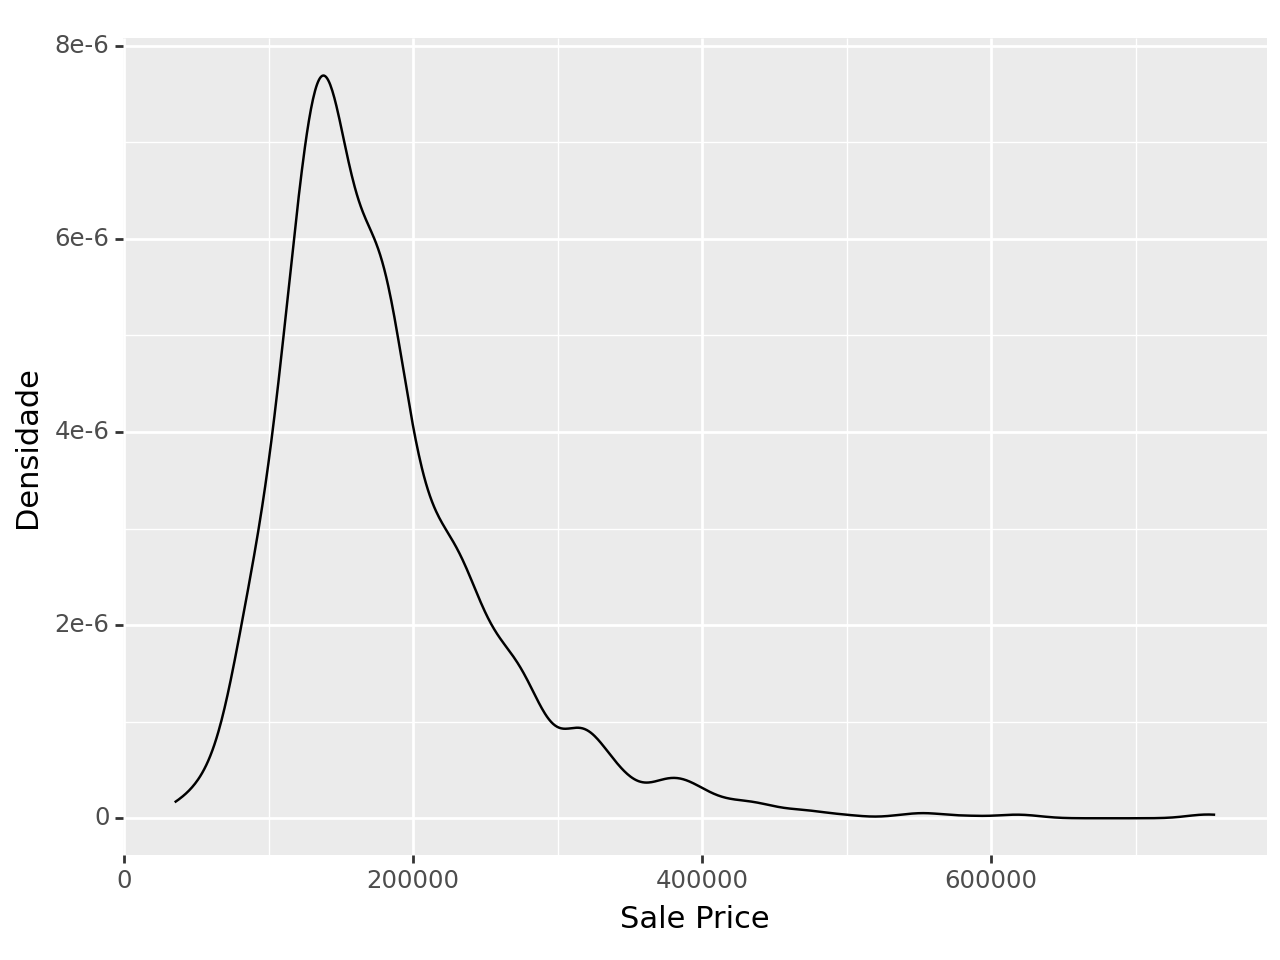

<Figure Size: (640 x 480)>

In [71]:
(
    ggplot(train_data)
        +geom_density(aes(x = "SalePrice"))
        +labs(x = "Sale Price", y = "Densidade")
)

To see if the **Sale Price** have approximadetly a Guassian Distribution, lets see the Skewness and Kurtosis of its data.

- Skewness measures the assymetry of a distribution and its definition is given by:

$$
A(X) = E\left[\frac{(X-\mu)^{3}}{\sigma^{3}}\right]
$$      

And its estimation is given by:

$$
\hat{A}(X) = \frac{1}{N\sigma^{3}}\sum_{n=1}^{N} (X_{n} - \bar{X})
$$

Where the Normal Distribution have A(X) = 0.

- Kurtosis measures the flatness and peakness of a distribution and its definition is given by:

$$
K(X) = E\left[\frac{(X-\mu)^{4}}{\sigma^{4}}\right]
$$

And its estimation is given by:

$$
\hat{X} = \frac{1}{N\sigma^{4}}\sum_{n=1}^{N} (X_{n}-\bar{X})^{4}
$$

Where the Normal Distribution have K(X) = 3.

In [72]:
print('Skewness:', train_data.SalePrice.skew(), '\nKurtosis: ', train_data.SalePrice.kurtosis())

Skewness: 1.8828757597682129 
Kurtosis:  6.536281860064529


We can observe that both the measurement are quite far from the Normal Distribution value, indicating that a linear regression might be not the best approach since its assumption is related to that.

### Correlation

#### Target x Original Features

In [73]:
correlacao = train_data.corr(method='spearman')['SalePrice'].to_frame()
correlacao.loc[correlacao.SalePrice > 0].sort_values(by=['SalePrice'], ascending=False)
#sort_values(by=['SalePrice'], ascending=False)[1:15]

C:\Users\kioia\AppData\Local\Temp\ipykernel_28540\2386978415.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,SalePrice
SalePrice,1.000000
OverallQual,0.809829
GrLivArea,0.731310
GarageCars,0.690711
YearBuilt,0.652682
GarageArea,0.649379
FullBath,0.635957
TotalBsmtSF,0.602725
GarageYrBlt,0.593788
1stFlrSF,0.575408


In [74]:
correlacao.loc[correlacao.SalePrice < 0].sort_values(by=['SalePrice'], ascending=True)

,SalePrice
EnclosedPorch,-0.218394
KitchenAbvGr,-0.164826
OverallCond,-0.129325
LowQualFinSF,-0.067719
MiscVal,-0.062727
BsmtFinSF2,-0.038806
YrSold,-0.029899
Id,-0.018546
BsmtHalfBath,-0.012189


## Pipeline

In [75]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from statsmodels.formula.api import ols
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#### Splitting data set

In [76]:
features = train_data.drop(['SalePrice'], axis=1)
target = train_data['SalePrice']

x_train, x_validation, y_train, y_validation = train_test_split(features, target, test_size = 0.3, random_state=11218195)

#### Listing categorical and numerical features

Taking the numerical and categorical features names and index for pipeline. 

In [77]:
categorical_features = list(x_train.select_dtypes(include=['object']).columns.tolist())
numerical_features = list(x_train.select_dtypes(exclude=['object']).columns.tolist())

categorical_features_index = [x_train.columns.get_loc(col) for col in categorical_features] 
numerical_features_index = [x_train.columns.get_loc(col) for col in numerical_features] 

#### Creating Transformers

For the numerical and categorical feature  I'm going to impute by median and mode, respectively. Next, I'll use Standardization for numerical and One Hot Encoder for categorical.

In [78]:
feature_engeneering = ColumnTransformer([
    ('total_area', FunctionTransformer(creating_total_area), 
        ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'LotArea']),
    ('total_bathrrom', FunctionTransformer(creating_total_bathroom),
        ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']),
    ('house_yr_old', FunctionTransformer(creating_house_yr_old),
        ['YrSold', 'YearBuilt'])
])

cat_transformer = Pipeline([
    ('fill_cat_na', SimpleImputer(strategy='most_frequent')),
    ('OneHot', OneHotEncoder())
])

num_transformer = Pipeline([
    ('fill_cat_na', SimpleImputer(strategy='median')),
    ('Strd', StandardScaler())
]) 

preprocessing = ColumnTransformer([
    ('fill_num_na', SimpleImputer(strategy='median'), numerical_features_index), 
    ('feature_engeneering', feature_engeneering, numerical_features_index), 
    ('cat_transformer', cat_transformer, categorical_features_index),
    ('num_transformer', num_transformer, numerical_features_index)
])


#### Creating Pipeline

The script below was used to search for the best parameters for each regression model, RIige, Lasso and Elastic Net, using Cross-Validation.


In [79]:
# ########################## This was used to search optimals alphas and l1 ######################
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=11218195)

# models_regression = [
#     linear_model.RidgeCV(alphas=np.arange(19, 40, 0.01), cv = cv),
#     linear_model.LassoCV(alphas=np.arange(50, 90, 0.1), cv = cv, tol = 0.001, n_jobs=-1, max_iter=5000),
#     linear_model.ElasticNetCV(l1_ratio=0.5, alphas=np.arange(0.01, 0.3, 0.01), cv = cv, n_jobs=-1, tol=0.001, max_iter=5000)
# ]

# erros = []

# for model in models_regression:
#     pipeline = Pipeline(
#         steps=[('pre_processing', preprocessing),
#                ('model', model)]
#     )
#     pipeline.fit(x_train, y_train)
#     predict = pipeline.predict(x_validation)
#     model_name = type(model).__name__
#     erros.append([model_name, np.sqrt(mean_squared_error(y_validation, predict))])

#     if model_name != 'ElasticNetCV':
#         modelo = pipeline[1]
#         lambd = modelo.alpha_
#         print("Optimal lambda for", model_name, ": ", lambd)
        
#     elif model_name == 'ElasticNetCV':
#         modelo = pipeline[1]
#         lambd = modelo.alpha_
#         print("Optimal (lambda, l1) for", model_name, ": ", (modelo.alpha_, modelo.l1_ratio_))

###################### Gradient Boosting ########################

# param_grid = {
#     'n_estimators': [50, 75, 100],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [5, 10, 15]
# }

# gb_regressor = GradientBoostingRegressor(random_state=11218195)

# grid_search = GridSearchCV(
#     gb_regressor, 
#     param_grid,
#     cv=cv,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# pipeline = Pipeline(
#     steps=[
#         ('pre_processing', preprocessing),
#         ('gradient_boosting', grid_search)
#     ]
# )

# pipeline.fit(x_train, y_train)

In [80]:
# modelo_boossting = pipeline[1]
# best_par = modelo_boossting.best_params_
# modelo_final_boosting = GradientBoostingRegressor(**best_par, random_state=11218195)
# best_par

In [81]:
# param_grid_rf = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [2, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# gb_regressor = GradientBoostingRegressor(random_state=11218195)

# grid_search = GridSearchCV(
#     gb_regressor, 
#     param_grid,
#     cv=cv,
#     scoring='neg_mean_squared_error'
# )

# pipeline = Pipeline(
#     steps=[
#         ('pre_processing', preprocessing),
#         ('gradient_boosting', grid_search)
#     ]
# )

# pipeline.fit(x_train, y_train)

The next scrpit was used to evaluate the validation error, in order to choose the best model.

In [82]:
######################################## USED FOR COMPARISON ########################################
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=11218195)

models_regression = [
    linear_model.Ridge(alpha=21.31000000000036),
    linear_model.Lasso(alpha=77.6, tol = 0.001),
    linear_model.ElasticNet(l1_ratio=0.5, alpha=0.04, tol=0.001)
    # GradientBoostingRegressor('learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100)
]

# models_stepwise = [
#     sfs(linear_model.LinearRegression(), k_features='best', cv=cv, forward=True, floating=False, scoring='neg_mean_squared_error', n_jobs=-1)
#     # sfs(linear_model.LinearRegression(), k_features='best', cv=cv, forward=False, floating=False, scoring='neg_mean_squared_error', n_jobs=-1)
# ]

erros = []

for model in models_regression:
    pipeline = Pipeline(
        steps=[('pre_processing', preprocessing),
               ('model', model)]
    )
    pipeline.fit(x_train, y_train)
    predict = pipeline.predict(x_validation)
    model_name = type(model).__name__
    erros.append([model_name, np.sqrt(mean_squared_error(y_validation, predict))])

# for model in models_stepwise:
#     pipeline = Pipeline(
#         steps=[('pre_processing', preprocessing),
#                ('sfs', model),
#                 ('linear_regression', linear_model.LinearRegression())]
#     )
#     pipeline.fit(x_train, y_train)
#     predict = pipeline.predict(x_validation)
#     model_name = type(model).__name__
#     erros.append([model_name, np.sqrt(mean_squared_error(y_validation, predict))])



c:\Users\kioia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.010e+11, tolerance: 6.399e+09



c:\Users\kioia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.682e+11, tolerance: 6.399e+09



In [83]:
pd.DataFrame(erros).rename(columns={0: 'Model', 1: 'Validation Error'})

,Model,Validation Error
0,Ridge,28732.936007
1,Lasso,27976.140721
2,ElasticNet,28750.001240


For the valdiation error the sample, the best model is Lasso, with alpha equal to 77.6.

#### Forcasting test data set

Predicting the test data set.

In [84]:
################## PREDICT TEST DATA SET #################
pipeline = Pipeline(
    steps=[('pre_processing', preprocessing),
           ('model', linear_model.Lasso(alpha=77.6, tol = 0.001))]
)

# imputer = SimpleImputer(strategy='median')
# test_data_temp = test_data.copy()
# test_data_temp[numerical_features] = imputer.fit_transform(test_data_temp[numerical_features])
# imputer = SimpleImputer(strategy='most_frequent')
# test_data_temp[categorical_features] = imputer.fit_transform(test_data_temp[categorical_features])

pipeline.fit(x_train, y_train)
predict = pipeline.predict(test_data)

c:\Users\kioia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.010e+11, tolerance: 6.399e+09



ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Exporting to a csv file, names *predict_house_prices.csv*

In [ ]:
# pd.DataFrame(predict).rename(columns={0: 'predict'}).to_csv('../SUBMISSION/predict_house_prices.csv')

OSError: Cannot save file into a non-existent directory: '..\Projeto\SUBMISSION'